In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 15, 8
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

# Task 7. Buckley-Ostgus model

In [147]:
def group_by_m_nodes(G, m):
    new_G = nx.MultiGraph()
    n = len(G) // m
    
    new_G.add_nodes_from(np.arange(n) + 1)
    
    for n1, n2 in G.edges():
        new_G.add_edge(n1 // m + n1 % m, n2 // m + n2 % m)
    return new_G

In [148]:
def buckley_ostgus_generate(a, n, m):
    main_graph = nx.Graph()
    main_graph.add_node(1)
    main_graph.add_edge(1, 1)

    for i in range(2, n * m + 1):
        main_graph.add_node(i)
        denum = (a + 1) * i - 1
        probs_list = [(deg + a - 1) / denum 
                      if node != i else a / denum for (node, deg) in main_graph.degree()]
        v_j = np.array(main_graph.nodes)[np.random.uniform() < np.cumsum(probs_list)][0]

        main_graph.add_edge(i, v_j)
    
    return group_by_m_nodes(main_graph, m)

In [149]:
n = 5000
a = 0.27
m = 2

In [152]:
%%time
G = buckley_ostgus_generate(a, n, m)

Wall time: 1min 49s


In [153]:
from collections import defaultdict

def get_degrees_distr(G: nx.Graph):
    degrees = defaultdict(int)

    for v in G.nodes():
        d = G.degree(v)
        degrees[d] += 1
    return degrees

In [273]:
def plot_degrees(degrees: defaultdict,
                 ax1, ax2,
                 _type=None,
                 after_d=None
                ):
    sorted_idxs = np.argsort(list(degrees.keys()))
    sorted_keys = np.array(list(degrees.keys()))[sorted_idxs]
    sorted_values = np.array(list(degrees.values()))[sorted_idxs]
    if after_d is not None:
        mask = sorted_keys >= after_d
        sorted_keys = sorted_keys[mask]
        sorted_values = sorted_values[mask]
    ax1.scatter(sorted_keys, sorted_values, marker='.', label="Эксперимент")
    if _type is None:
        ax1.set_title("Распределение степеней вершин")  
        ax1.set_ylabel("Число вершин")
    else:
        ax1.set_title(f"{_type} распределение степеней вершин")  
        ax1.set_ylabel(f"{_type} число вершин")
    ax1.set_xlabel("Полная cтепень вершины")
    
    ax2.loglog(sorted_keys, sorted_values, ls='', marker='.', markersize=10, label="Эксперимент")
    if _type is None:
        ax2.set_title("Распределение степеней вершин (log)")  
        ax2.set_ylabel("Число вершин (log)")
    else:
        ax2.set_title(f"{_type} распределение степеней вершин (log)")  
        ax2.set_ylabel(f"{_type} число вершин (log)")
    ax2.set_xlabel("Полная cтепень вершины (log)")

C:\Users\Georgy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


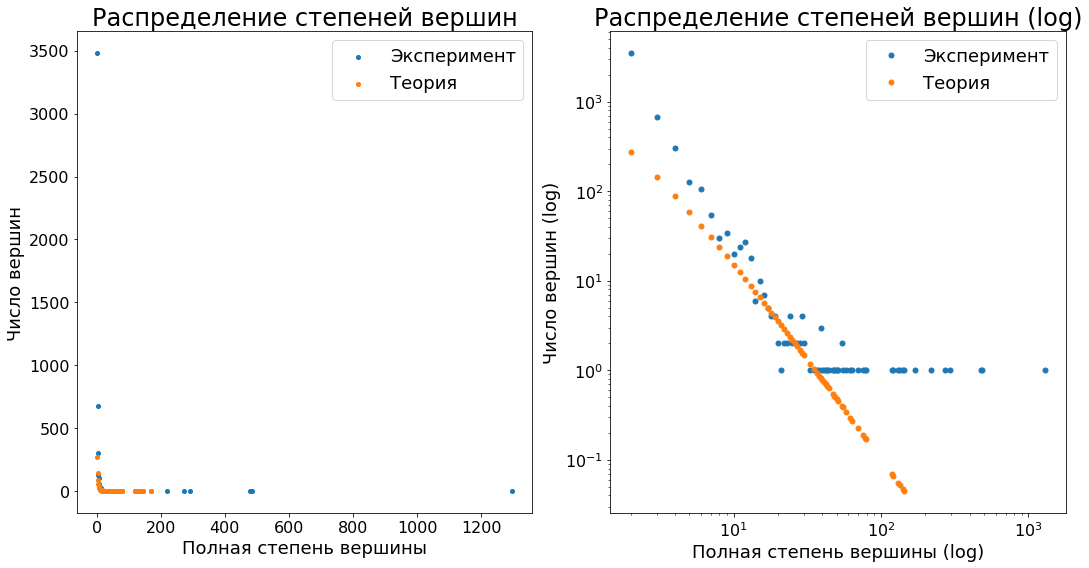

In [195]:
from scipy.special import binom, factorial


degrees = get_degrees_distr(G)
theoretical_degrees = lambda d, a, m, n: (a+1) * factorial(a*m + a, exact=False) * binom(d+a*m-1, a*m-1) * factorial(d, exact=False) / factorial(d + a*m + a + 1, exact=False) * n
th_degrees = theoretical_degrees(np.array(list(degrees.keys())), a, m, n)

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_degrees(degrees, ax1, ax2)
ax1.scatter(degrees.keys(), th_degrees, marker='.', label="Теория", alpha=1)
ax2.loglog(degrees.keys(), th_degrees, ls='', marker='.', markersize=10, label="Теория", alpha=1)

plt.tight_layout()
ax2.legend()
ax1.legend()
plt.savefig("graph_7_1.jpg")

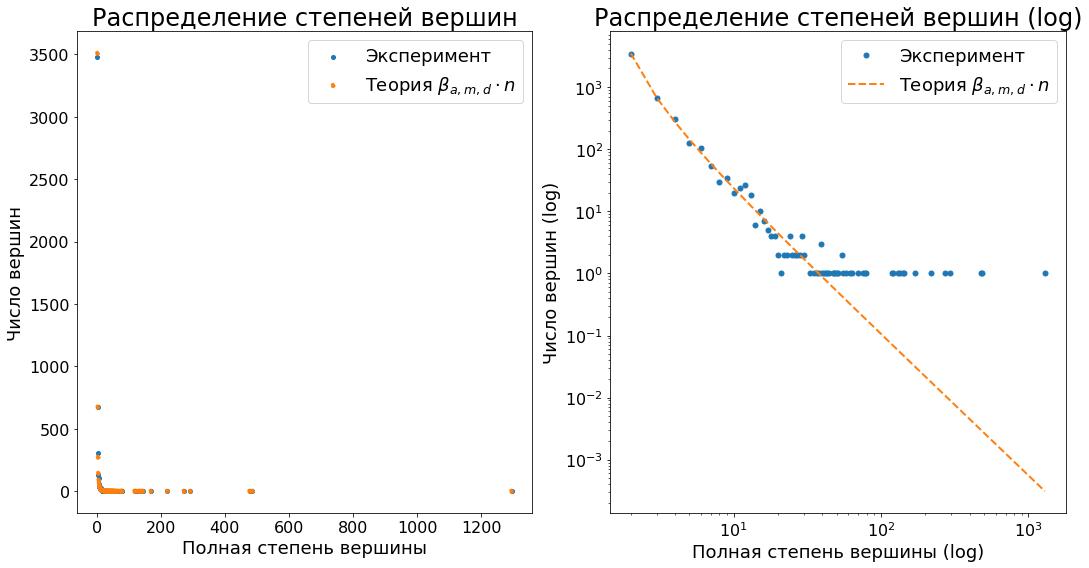

In [203]:
from scipy.special import beta
theoretical_degrees_2 = lambda d, a, m, n: beta(d - m + m*a, a + 2)/beta(m*a, a+1) * n
th_degrees_2 = theoretical_degrees_2(np.array(list(degrees.keys())), a, m, n)

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_degrees(degrees, ax1, ax2)
ax1.scatter(degrees.keys(), th_degrees_2, marker='.', linestyles='--', label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)
sort_idxs = np.argsort(list(degrees.keys()))
ax2.loglog(np.array(list(degrees.keys()))[sort_idxs], th_degrees_2[sort_idxs], ls='--', markersize=10, label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)

plt.tight_layout()
ax2.legend()
ax1.legend()
plt.savefig("graph_7_2.jpg")

### Optimization

In [216]:
def group_by_m_nodes_opt(G, m):
    new_G = nx.MultiGraph()
    n = len(G) // m
    
    new_G.add_nodes_from(np.arange(n) + 1)
    
    for n1, n2 in G.edges():
        new_G.add_edge(n1 // m + n1 % m, n2 // m + n2 % m)
    return new_G

In [254]:
def buckley_ostgus_generate_opt(a, n, m):
    main_graph = nx.Graph()
    main_graph.add_node(1)
    main_graph.add_edge(1, 1)

    degrees = np.zeros(n*m)
    degrees[0] = 2
    for i in range(2, n * m + 1):
        main_graph.add_node(i)
        degrees[i - 1] += 1
        
        denum = (a + 1) * i - 1
        probs_list = np.cumsum((degrees[: i] + a - 1) / denum)
        v_j = np.arange(1, i+1)[np.random.uniform() < probs_list][0]

        main_graph.add_edge(i, v_j)
        degrees[v_j - 1] += 1
    
    return group_by_m_nodes_opt(main_graph, m)

In [228]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [256]:
n = 10000
a = 0.27
m = 5

In [255]:
%lprun -f buckley_ostgus_generate_opt buckley_ostgus_generate_opt(0.27, 5000, 2)

Timer unit: 1e-07 s

Total time: 2.38561 s
File: <ipython-input-254-e39ad1edd18e>
Function: buckley_ostgus_generate_opt at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def buckley_ostgus_generate_opt(a, n, m):
     2         1        223.0    223.0      0.0      main_graph = nx.Graph()
     3         1         80.0     80.0      0.0      main_graph.add_node(1)
     4         1         83.0     83.0      0.0      main_graph.add_edge(1, 1)
     5                                           
     6         1        353.0    353.0      0.0      degrees = np.zeros(n*m)
     7         1         48.0     48.0      0.0      degrees[0] = 2
     8     10000     160893.0     16.1      0.7      for i in range(2, n * m + 1):
     9      9999     902302.0     90.2      3.8          main_graph.add_node(i)
    10      9999     403080.0     40.3      1.7          degrees[i - 1] += 1
    11                                          

In [257]:
%lprun -f buckley_ostgus_generate_opt buckley_ostgus_generate_opt(a, n, m)

Timer unit: 1e-07 s

Total time: 26.252 s
File: <ipython-input-254-e39ad1edd18e>
Function: buckley_ostgus_generate_opt at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def buckley_ostgus_generate_opt(a, n, m):
     2         1        191.0    191.0      0.0      main_graph = nx.Graph()
     3         1         77.0     77.0      0.0      main_graph.add_node(1)
     4         1         78.0     78.0      0.0      main_graph.add_edge(1, 1)
     5                                           
     6         1       2710.0   2710.0      0.0      degrees = np.zeros(n*m)
     7         1         65.0     65.0      0.0      degrees[0] = 2
     8     50000     813431.0     16.3      0.3      for i in range(2, n * m + 1):
     9     49999    4669095.0     93.4      1.8          main_graph.add_node(i)
    10     49999    2032436.0     40.6      0.8          degrees[i - 1] += 1
    11                                           

In [266]:
%%time
G_big = buckley_ostgus_generate_opt(a, n, m)

Wall time: 28.9 s


**Check, that algorithm is still ok**

C:\Users\Georgy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


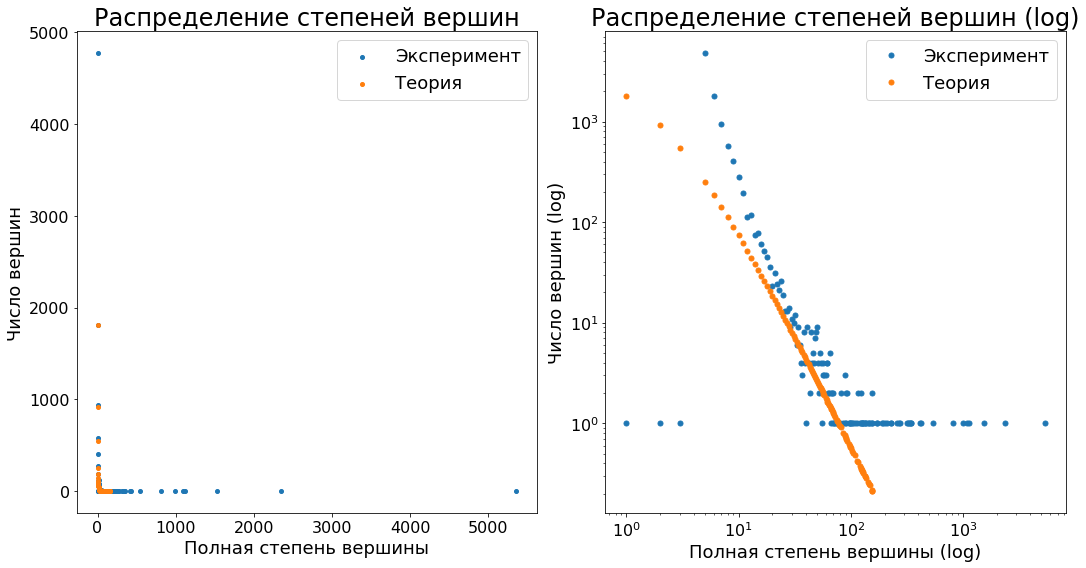

In [275]:
degrees = get_degrees_distr(G_big)
th_degrees = theoretical_degrees(np.array(list(degrees.keys())), a, m, n)

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_degrees(degrees, ax1, ax2)
ax1.scatter(degrees.keys(), th_degrees, marker='.', label="Теория", alpha=1)
ax2.loglog(degrees.keys(), th_degrees, ls='', marker='.', markersize=10, label="Теория", alpha=1)

plt.tight_layout()
ax2.legend()
ax1.legend()

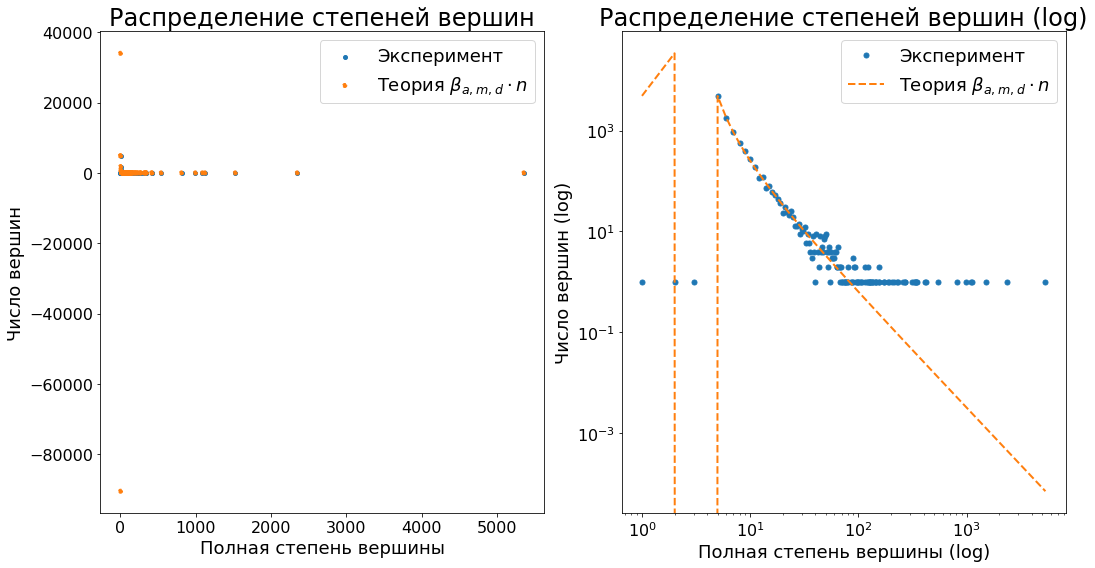

In [280]:
th_degrees_2 = theoretical_degrees_2(np.array(list(degrees.keys())), a, m, n)

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_degrees(degrees, ax1, ax2)
ax1.scatter(degrees.keys(), th_degrees_2, marker='.', linestyles='--', label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)
sort_idxs = np.argsort(list(degrees.keys()))
ax2.loglog(np.array(list(degrees.keys()))[sort_idxs], th_degrees_2[sort_idxs], ls='--', markersize=10, label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)

plt.tight_layout()
ax2.legend()
ax1.legend()

**ВАЖНО! Выбросы из распределения в малых степенях связаны с нарушением выполнения условия теоремы. ТРЕБУЕТСЯ d >= m!!**

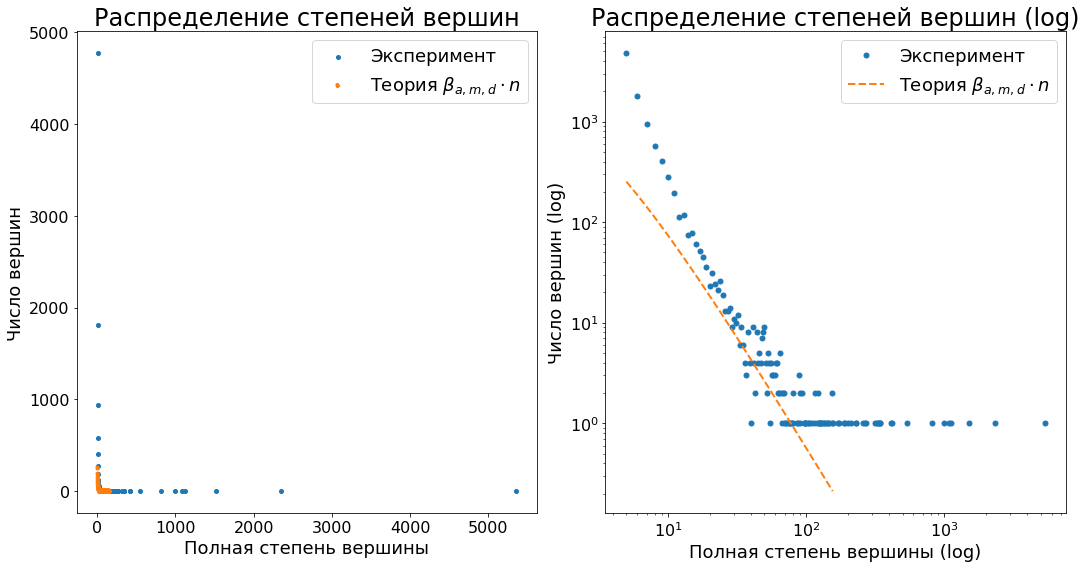

In [281]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_degrees(degrees, ax1, ax2, after_d=m)
sort_idxs = np.argsort(list(degrees.keys()))
sorted_degrees = np.array(list(degrees.keys()))[sort_idxs]
mask = sorted_degrees >= m
ax1.scatter(sorted_degrees[mask], th_degrees[sort_idxs][mask], marker='.', linestyles='--', label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)

ax2.loglog(sorted_degrees[mask], th_degrees[sort_idxs][mask], ls='--', markersize=10, label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)

plt.tight_layout()
ax2.legend()
ax1.legend()

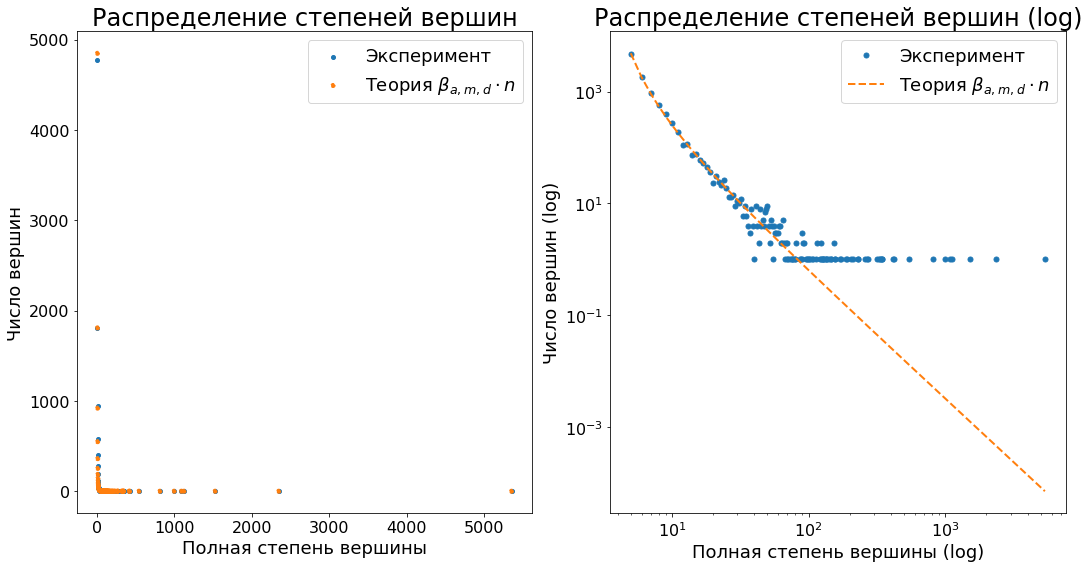

In [278]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_degrees(degrees, ax1, ax2, after_d=m)
sort_idxs = np.argsort(list(degrees.keys()))
sorted_degrees = np.array(list(degrees.keys()))[sort_idxs]
mask = sorted_degrees >= m
ax1.scatter(sorted_degrees[mask], th_degrees_2[sort_idxs][mask], marker='.', linestyles='--', label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)
ax2.loglog(sorted_degrees[mask], th_degrees_2[sort_idxs][mask], ls='--', markersize=10, label=r"Теория $\beta_{a,m,d} \cdot n$", alpha=1)

plt.tight_layout()
ax2.legend()
ax1.legend()

**Results:**

- Реализована неоптимизированная версия модели Бакли–Остгуса с сохранением степенного закона
- Построены требуемые иллюстрации
- Код оптимизирован для запуска при больших n, например, n=10000, m=5, a=0.27
- Для демонстрации сохранения качества алгоритма, приведены визуализации, схожие с прошлым пунктом при соблюдении условия $d\geq m$

# Task 8

Поскольку порядок рёбер гарантированно совпадает по условию с порядком при генерации, то логарифм правдоподобия можно оценивать, исходя из того, какое ребро было выбрано с какой вероятностью.

Общая схема оценка правдоподобия следующая:
$\log \mathcal{L}(G(t)| \alpha, \beta, \gamma, \delta_{out}, \delta_{in}) = \sum\limits_{i=2}^t \log(\mathbb{P}(G(i)| G(i-1))) + \log(\mathbb{P}(G(1)))$


Сразу неясно из задания, как можно получить треугольник моделью Боллобаша-Боргса-Риордана-Чайеса, но, видимо, это модель, начинающая с произвольного графа.

In [347]:
alpha = 0.5
beta = 0.5
gamma = 0

delta_in = np.arange(1e-6, 100, 0.01, dtype='float64')
delta_out = 0

In [348]:
from collections import defaultdict
from tqdm.notebook import tqdm

in_degrees = defaultdict(int)
out_degrees = defaultdict(int)
nodes = set()

nodes_amnt = 0
log_likelihood = np.zeros_like(delta_in)

with open("graph.txt", "r") as f:
    edges = f.readlines()
    
init_graph = edges[: 3]
for e in init_graph:
    v1, v2 = e.strip().split()
    in_degrees[v2] += 1
    out_degrees[v1] += 1
    nodes.add(v1)
    nodes.add(v2)
    
nodes_amnt = len(nodes)
t = 2
for e in tqdm(edges[3: ]):
    v1, v2 = e.strip().split()
    
    if v1 in nodes and v2 in nodes:
        log_likelihood += (np.log(beta) +
                           np.log(out_degrees[v1] + delta_out) -
                           np.log(t - 1 + delta_out*nodes_amnt) +
                           np.log(in_degrees[v2] + delta_in) - 
                           np.log(t - 1 + delta_in*nodes_amnt)
                          )
    else:
        log_likelihood += (np.log(alpha) + 
                           np.log(in_degrees[v2] + delta_in) -
                           np.log(t - 1 + delta_in*nodes_amnt))
    in_degrees[v2] += 1
    out_degrees[v1] += 1
    nodes.add(v1)
    nodes.add(v2)
    nodes_amnt = len(nodes)
    t += 1
    

  0%|          | 0/25027 [00:00<?, ?it/s]

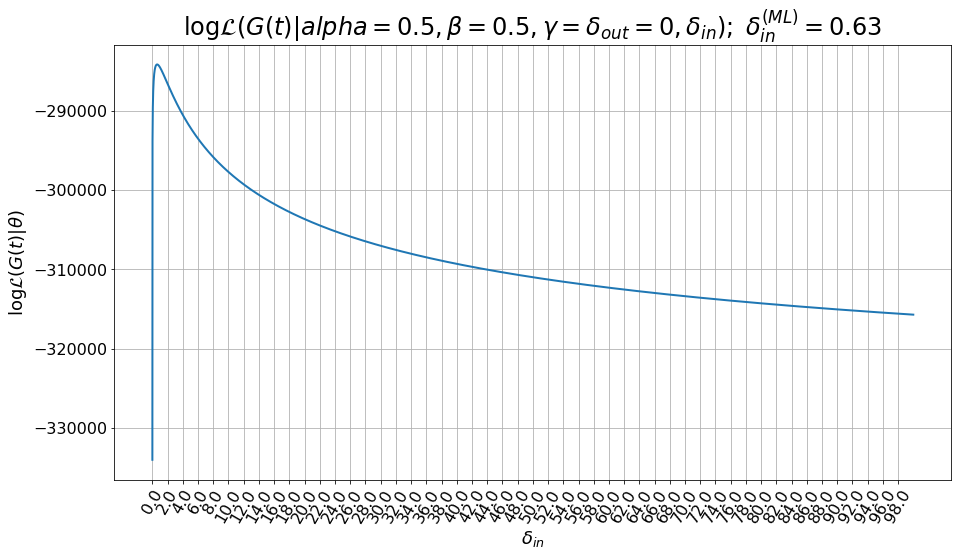

In [352]:
plt.plot(delta_in, log_likelihood)
plt.xticks(np.round(delta_in[::200], 2), np.round(delta_in[::200], 2), rotation=60)
plt.xlabel(r"$\delta_{in}$")
plt.ylabel(r"$\log \mathcal{L}(G(t)|\theta)$")
plt.title(r"$\log \mathcal{L}(G(t)|alpha=0.5, \beta=0.5, \gamma=\delta_{out}=0, \delta_{in}); \; \delta^{(ML)}_{in} =" 
          + f"{delta_in[np.argmax(log_likelihood)]:.2f}"+"$")
plt.grid(True)
plt.savefig("graph_8.jpg")

In [353]:
delta_in[np.argmax(log_likelihood)]

0.630001

**Оптимальное значение, при котором появление данного графа наиболее правдоподобно с точностью до второго знака равно $\delta_{in} = 0.63$**

# Task 9

In [433]:
G_i = nx.Graph()

G_i.add_nodes_from([0, 1])
G_i.add_edge(0, 1)

In [434]:
degree_2_ratio = []

for t in tqdm(range(2, 10000)):
    G_i.add_node(t)
    n_edges = len(G_i.edges())
    v1, v2 = list(G_i.edges())[np.random.choice(np.arange(n_edges))]
    G_i.add_edge(t, v2)
    G_i.add_edge(t, v1)
    
    degree_2_ratio.append(sum([1 if v == 2 else 0 for _, v in G_i.degree()]) / len(G_i.nodes()))

  0%|          | 0/9998 [00:00<?, ?it/s]

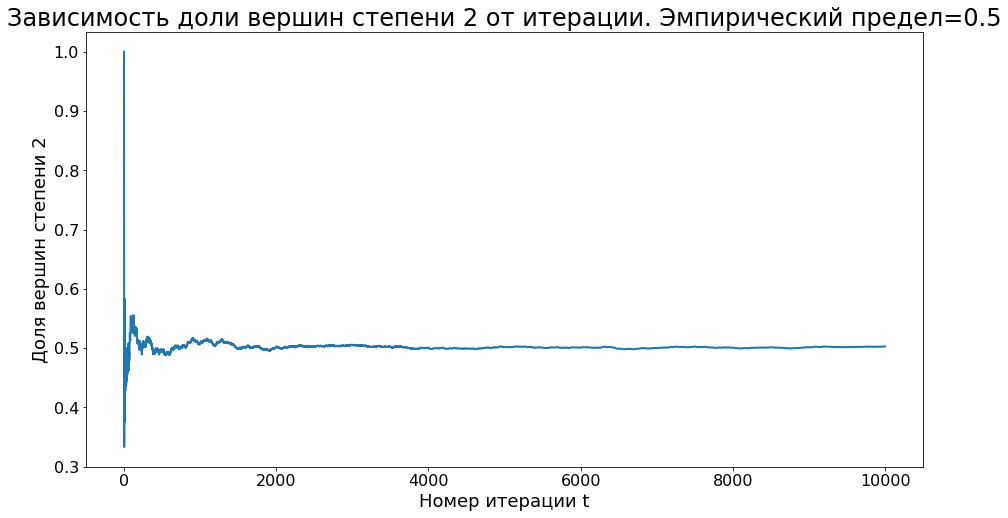

In [436]:
plt.plot(degree_2_ratio)
plt.xlabel("Номер итерации t")
plt.ylabel("Доля вершин степени 2")
plt.title("Зависимость доли вершин степени 2 от итерации. Эмпирический предел=0.5")
plt.savefig("graph_9.jpg");